In [1]:
import numpy as np
import scipy.special as scispec
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, pulse, transpile, IBMQ
from qiskit.circuit import Gate, Parameter
from qiskit.test.mock import FakeValencia

In [2]:
## Using a mock pulse device
backend = FakeValencia()

## To test on a real device
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
# backend = provider.get_backend('ibmq_lima')

## Understanding the background

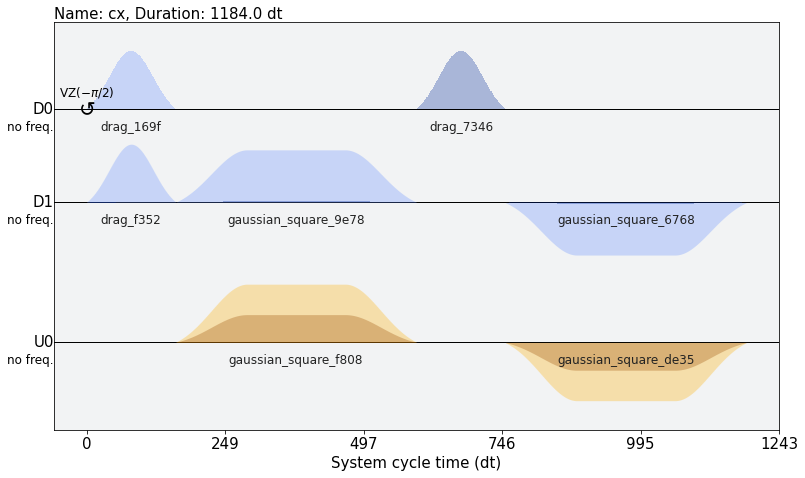

In [3]:
## Predefined CX schedule
cx_schedule = backend.defaults().instruction_schedule_map.get('cx', (0, 1))
cx_schedule.draw()

Note: CX schedule (in the native direction - see below) is equivalent to the following circuit, although for some reason IBM implements the first part as $YR_{z}(-\pi/2)$ instead of $XR_{z}(\pi/2)$ ($Y=XR_{z}(-\pi)$)

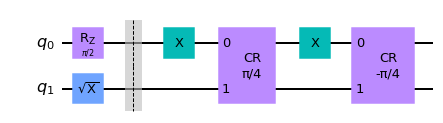

In [4]:
cr1 = Gate('cr1', 2, [], 'CR\nπ/4')
cr2 = Gate('cr2', 2, [], 'CR\n-π/4')

circuit = QuantumCircuit(2)
circuit.rz(np.pi / 2., 0)
circuit.sx(1)
circuit.barrier()
circuit.x(0)
circuit.append(cr1, (0, 1))
circuit.x(0)
circuit.append(cr2, (0, 1))
circuit.draw('mpl')

The entirety of the part after the barrier corresponds to an $R_{zx}(-\pi/2)$ gate. Splitting the CR gate into two halves (and sandwiching the first part with two X pulses) is necessary because the cross resonance pulse effects various terms in the two-qubit Hamiltonian aside from $ZX$. There is also a simultaneous "rotary" pulse applied to the target qubit for each cross resonance pulse, which further suppresses unwanted Hamiltonian terms. See https://link.aps.org/doi/10.1103/PRXQuantum.1.020318 (section II in particular) for a nice introduction.

## Actual code
### Function to generate the $R_{zx}$ schedule

In [5]:
def pulse_efficient_rzx_schedule(theta, backend, z_qubit, x_qubit, name='rzx'):
    """Return a Schedule that implements Rzx(theta)
    """
    
    if theta == 0.:
        return pulse.Schedule(name=name)
    
    # Use pulse.build for convenience to find the drive channels
    with pulse.build(backend=backend):
        z_qubit_drive = pulse.drive_channel(z_qubit)
        x_qubit_drive = pulse.drive_channel(x_qubit)
        control_drive = pulse.control_channels(z_qubit, x_qubit)[0]

    # Find the pulse shapes to be used as templates
    calibrations = backend.defaults().instruction_schedule_map
    x_schedule = calibrations.get('x', z_qubit)
    cx_schedule = calibrations.get('cx', (z_qubit, x_qubit))

    # X pulse
    x_pulse = next(inst.pulse for _, inst in x_schedule.instructions if type(inst) is pulse.Play)
    # CR(pi/4) pulse
    cx_cr_time, cx_cr_pulse = next((t, inst.pulse) for t, inst in cx_schedule.instructions if type(inst) is pulse.Play and inst.channel == control_drive)
    # Rotary pulse for CR(pi/4)
    cx_rotary_pulse = next(inst.pulse for t, inst in cx_schedule.instructions if type(inst) is pulse.Play and inst.channel == x_qubit_drive and t == cx_cr_time)

    cr_amp = cx_cr_pulse.amp
    crr_amp = cx_rotary_pulse.amp
    sigma = cx_cr_pulse.sigma
    flank_width = (cx_cr_pulse.duration - cx_cr_pulse.width) // 2

    # Integral of a nominal Gaussian corresponding to the flanks of the GaussianSquare pulse
    normal_flank_integral = np.sqrt(np.pi / 2.) * sigma * scispec.erf(flank_width / np.sqrt(2.) / sigma)
    # In Qiskit pulse, truncated Gaussian(Square) pulses are "grounded" so that the pulse amplitude of the tail is always zero
    pedestal = np.exp(-0.5 * np.square(flank_width / sigma))
    grounded_flank_integral = (normal_flank_integral - pedestal * flank_width) / (1. - pedestal)
    flank_area = np.abs(cr_amp) * grounded_flank_integral
    # Total area of the CR(pi/4) pulse
    cr45_area_norm = np.abs(cr_amp) * cx_cr_pulse.width + 2. * flank_area
    # Theta value to switch between scaling the width versus amplitude of the Gaussian(Square) pulse
    minimum_theta = 2. * np.pi / 4. * (2. * flank_area) / cr45_area_norm

    theta_label = int(np.round(theta / np.pi * 180.))

    if abs(theta) <= minimum_theta:
        # theta is below the threshold; use a amplitude-scaled Gaussian pulse
        
        amp_ratio = theta / minimum_theta
        if theta < 0.:
            amp_ratio *= -1.
        duration = 2 * flank_width
        
        cr_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * cr_amp), sigma=sigma, name='CR{}p_u{}'.format(theta_label, control_drive.index))
        cr_rotary_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * crr_amp), sigma=sigma, name='CR{}p_d{}_u{}'.format(theta_label, x_qubit_drive.index, control_drive.index))
        cr_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * cr_amp), sigma=sigma, name='CR{}m_u{}'.format(theta_label, control_drive.index))
        cr_rotary_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * crr_amp), sigma=sigma, name='CR{}m_d{}_u{}'.format(theta_label, x_qubit_drive.index, control_drive.index))
    else:
        # theta is above the threshold; use a width-scaled GaussianSquare pulse
        
        area = theta / 2. / (np.pi / 4.) * cr45_area_norm
        width = (area - 2. * flank_area) / np.abs(cr_amp)
        duration = int(np.round((width + 2 * flank_width) / 16.)) * 16 # Duration must be a multiple of 16 (hardware constraint)
        sign = 1. if theta > 0. else -1.
        
        cr_pulse = pulse.GaussianSquare(duration=duration, amp=(sign * cr_amp), sigma=sigma, width=width, name='CR{}p_u{}'.format(theta_label, control_drive.index))
        cr_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=(sign * crr_amp), sigma=sigma, width=width, name='CR{}p_d{}_u{}'.format(theta_label, x_qubit_drive.index, control_drive.index))
        cr_echo = pulse.GaussianSquare(duration=duration, amp=-(sign * cr_amp), sigma=sigma, width=width, name='CR{}m_u{}'.format(theta_label, control_drive.index))
        cr_rotary_echo = pulse.GaussianSquare(duration=duration, amp=-(sign * crr_amp), sigma=sigma, width=width, name='CR{}m_d{}_u{}'.format(theta_label, x_qubit_drive.index, control_drive.index))

    with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as rzx_sched:
        pulse.play(x_pulse, z_qubit_drive, name=x_pulse.name)
        
        with pulse.align_left():
            pulse.play(cr_echo, control_drive, name=cr_echo.name)
            pulse.play(cr_rotary_echo, x_qubit_drive, name=cr_rotary_echo.name)

        pulse.play(x_pulse, z_qubit_drive, name=x_pulse.name)

        ## forward
        with pulse.align_left():
            pulse.play(cr_pulse, control_drive, name=cr_pulse.name)
            pulse.play(cr_rotary_pulse, x_qubit_drive, name=cr_rotary_pulse.name)

    return rzx_sched

### Using the schedule in a circuit

In [6]:
## Physical qubit numbers on the device
## Note 1: the following procedure must be repeated for every pair of physical qubits.
## Note 2: CX schedules in IBMQ have "native directions" - for example the CR part of cx(1, 2) on FakeValencia is actually implemented as [HH CR(2, 1) HH]. The function above assumes Z and X qubits in the native direction.
z_qubit = 2
x_qubit = 1

thetas = np.linspace(0., np.pi, 10)
circuits_0 = []
circuits_1 = []

for theta in thetas:
    rzx_sched = pulse_efficient_rzx_schedule(theta, backend, z_qubit, x_qubit, name='rzx_{:.1f}pi'.format(theta / np.pi))
    rzx_gate = Gate('rzx', 2, [], label='R_{{zx}}\n{}'.format(theta))

    ## Circuit with the z qubit in |0> state
    circuit = QuantumCircuit(2)
    circuit.append(rzx_gate, (0, 1)) # Append onto logical qubit number
    circuit.add_calibration(rzx_gate.name, (z_qubit, x_qubit), rzx_sched) # Add the calibration in terms of physical qubit numbers
    circuit.measure_all()
    circuits_0.append(circuit)

    ## Circuit with the z qubit in |1> state
    circuit = QuantumCircuit(2)
    circuit.x(0)
    circuit.append(rzx_gate, (0, 1)) # Append onto logical qubit number
    circuit.add_calibration(rzx_gate.name, (z_qubit, x_qubit), rzx_sched) # Add the calibration in terms of physical qubit numbers
    circuit.measure_all()
    circuits_1.append(circuit)
    
circuits_0 = transpile(circuits_0, backend=backend, initial_layout=[z_qubit, x_qubit], optimization_level=0)
circuits_1 = transpile(circuits_1, backend=backend, initial_layout=[z_qubit, x_qubit], optimization_level=0)

In [ ]:
counts_0 = backend.run(circuits_0).result().get_counts()
counts_1 = backend.run(circuits_1).result().get_counts()

plt.scatter(thetas, [cnt.get('00', 0) for cnt in counts_0], label=r'$|0\rangle$')
plt.scatter(thetas, [cnt.get('00', 0) for cnt in counts_1], label=r'$|1\rangle$')